<a href="https://colab.research.google.com/github/jenelaineDC/Master-Time-Series-Analysis-Forecasting/blob/main/GOOGLE%20TSMIXER/GoogleTSMixer_Coffee_Sales_Multivariate_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Course Challenge:

We aim to implement an advanced time series forecasting solution to predict coffee shop sales across three European countries. This project will leverage the TSMixer model to improve sales forecasting accuracy, optimize resource allocation, and support better decision-making.

Key Goals:
1. Accurate Forecasting: Deliver precise daily sales forecasts across locations by minimizing prediction errors.
2. Data Utilization: Integrate both historical and future data, using relevant features to enhance model performance.
3. Scalability: Ensure the solution is scalable across multiple locations and adaptable to changes in data.
4. Performance Optimization: Use cross-validation and parameter tuning to achieve the best model performance.


Requirements:
1. Data Preparation
- Process historical sales data and future covariates from provided datasets.
- Clean and structure the data, converting time and location information into appropriate formats.
- Scale the data for effective model training.

2. Exploratory Analysis
- Analyze and visualize sales trends across locations.
- Generate a correlation matrix to identify relationships between key variables.

3. Model Development
- Train the TSMixer model using grouped time series for each location, leveraging past and future covariates.
- Configure the model with appropriate input/output parameters and use GPU acceleration for efficiency.

4. Performance Validation
- Perform rolling forecasts and backtesting, assessing model accuracy with Root Mean Squared Error (RMSE).
- Visualize actual vs predicted sales to ensure forecast reliability.

5. Parameter Tuning
- Optimize model performance through parameter tuning, testing multiple configurations to minimize RMSE.

6. Final Forecasting
- Use the tuned model to generate 30-day sales forecasts for each location.
- Present forecasts alongside visualizations for decision-making.


### SET-UP

In [1]:
# Install the darts library
!pip install -q darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.8/344.8 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import logging
import warnings
from pytorch_lightning.utilities import rank_zero_warn

# Suppress Python warnings (optional)
warnings.filterwarnings("ignore")

# Suppress Darts / PyTorch Lightning INFO messages
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
logging.getLogger("pytorch_lightning.utilities.rank_zero").setLevel(logging.ERROR)
logging.getLogger("darts").setLevel(logging.ERROR)

# Suppress specific Darts warnings
rank_zero_warn = lambda *args, **kwargs: None  # ignore rank_zero_warn calls


In [3]:
# Mount Drive to access files
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/Python - Time Series Forecasting/Advanced Content for Time Series/Project - Google TS Mixer

/content/drive/MyDrive/Python - Time Series Forecasting/Advanced Content for Time Series/Project - Google TS Mixer


In [5]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import ParameterSampler

# Darts functions
from darts.timeseries import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import TSMixerModel

In [6]:
df = pd.read_excel('special_coffee_sales_data.xlsx')
df.head()

menu_name location       date  sales  temperature  holiday_flag  \
0  Special Coffee Blend  Germany 2023-01-01    310   -14.682030             0   
1  Special Coffee Blend  Germany 2023-01-02     59    23.455472             0   
2  Special Coffee Blend  Germany 2023-01-03    757     6.094149             1   
3  Special Coffee Blend  Germany 2023-01-04    293    15.789124             0   
4  Special Coffee Blend  Germany 2023-01-05    261     5.847489             0   

   promotion_flag  social_media_mentions  
0               0                     18  
1               0                     15  
2               0                     19  
3               0                     24  
4               0                     13

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1188 entries, 0 to 1187
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   menu_name              1188 non-null   object        
 1   location               1188 non-null   object        
 2   date                   1188 non-null   datetime64[ns]
 3   sales                  1188 non-null   int64         
 4   temperature            1188 non-null   float64       
 5   holiday_flag           1188 non-null   int64         
 6   promotion_flag         1188 non-null   int64         
 7   social_media_mentions  1188 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 74.4+ KB


In [8]:
# Rename the column 'sales' to 'y'
df = df.rename(columns={'sales': 'y'})

# Create ds as datetime
df['ds'] = pd.to_datetime(df['date'])

# Drop date
df = df.drop(columns = ['date', 'menu_name'])

df.head()

location    y  temperature  holiday_flag  promotion_flag  \
0  Germany  310   -14.682030             0               0   
1  Germany   59    23.455472             0               0   
2  Germany  757     6.094149             1               0   
3  Germany  293    15.789124             0               0   
4  Germany  261     5.847489             0               0   

   social_media_mentions         ds  
0                     18 2023-01-01  
1                     15 2023-01-02  
2                     19 2023-01-03  
3                     24 2023-01-04  
4                     13 2023-01-05

In [9]:
# Convert the 'location' column to a categorical variable
df['location'] = df['location'].astype('category')

# Get the mapping between categories and codes
category_mapping = dict(enumerate(df['location'].cat.categories))
print(category_mapping)

# Convert the 'location' column to numerical codes
df['location'] = df['location'].cat.codes

# Preview
df.head()

{0: 'France', 1: 'Germany', 2: 'Italy'}


location    y  temperature  holiday_flag  promotion_flag  \
0         1  310   -14.682030             0               0   
1         1   59    23.455472             0               0   
2         1  757     6.094149             1               0   
3         1  293    15.789124             0               0   
4         1  261     5.847489             0               0   

   social_media_mentions         ds  
0                     18 2023-01-01  
1                     15 2023-01-02  
2                     19 2023-01-03  
3                     24 2023-01-04  
4                     13 2023-01-05

### EDA

In [10]:
# Group the DataFrame by the 'location' column and calculate the mean for each group
df.groupby('location').mean()

y  temperature  holiday_flag  promotion_flag  \
location                                                          
0         659.237374    14.994531      0.202020        0.171717   
1         622.095960    11.974621      0.159091        0.148990   
2         633.489899    18.895145      0.169192        0.136364   

          social_media_mentions                  ds  
location                                             
0                     25.303030 2023-07-17 12:00:00  
1                     24.651515 2023-07-17 12:00:00  
2                     24.237374 2023-07-17 12:00:00

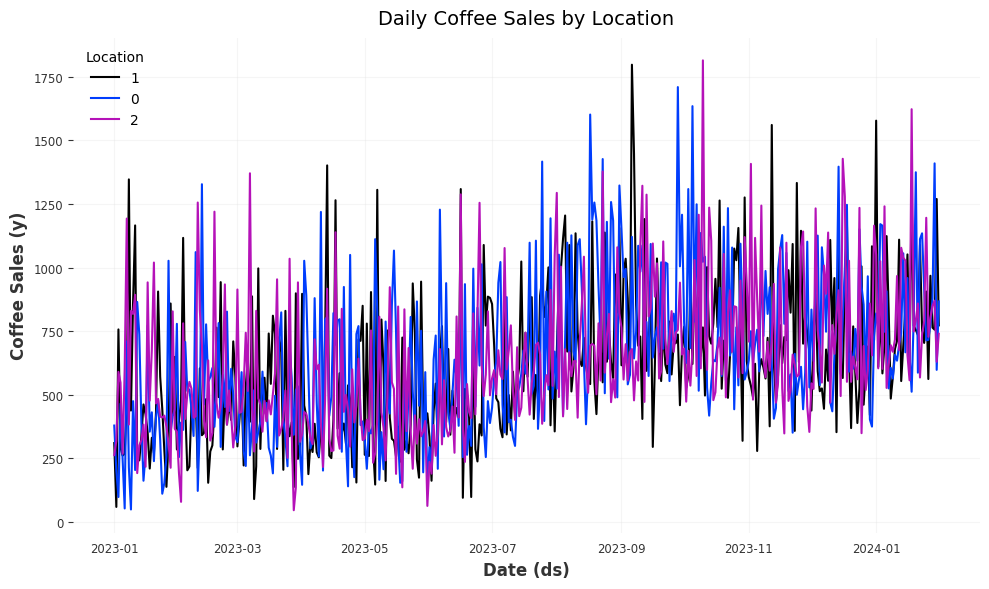

In [11]:
# Make a copy
temp_df = df.copy()

# Set as index
temp_df = temp_df.set_index('ds')


# Daily Coffee Sale Plot
plt.figure(figsize=(10,6))
for loc in temp_df['location'].unique():
    subset = temp_df[temp_df['location'] == loc]
    plt.plot(subset.index, subset['y'], label=loc, linewidth=1.5)

plt.title("Daily Coffee Sales by Location", fontsize=14, pad=10)
plt.xlabel("Date (ds)", fontsize=12)
plt.ylabel("Coffee Sales (y)", fontsize=12)
plt.legend(title="Location")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Data Preparation for Darts

[add_encoder](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.tsmixer_model.html?highlight=add_encoder)

[from_group_dataframe](https://unit8co.github.io/darts/generated_api/darts.timeseries.html?highlight=group_dataframe#darts.timeseries.TimeSeries.from_group_dataframe)

#### Encoder

In [12]:
#https://unit8co.github.io/darts/generated_api/darts.models.forecasting.tsmixer_model.html?highlight=add_encoder
def encode_year(idx):
  return (idx.year - 2000) / 50

# Set up the add_encoders dictionary to specify how different time-related encoders and transformers should be applied
add_encoders = {
    'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week','month']},             # Encodes cyclical time features (like sine/cosine of day-of-week, month, etc.).
    'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week','month']}, # Adds raw datetime features (like dayofweek = 0–6, month = 1–12).
    'position': {'past': ['relative'], 'future': ['relative']},                     # Adds relative position encodings (like “how far into the sequence are we”).
    'custom': {'past': [encode_year], 'future': [encode_year]},                     # Applies your encode_year function both to past and future.
    'transformer': Scaler(),                                                        # Applies scaling to the encoders so all features are normalized (important for neural models like TSMixer).
    'tz': 'CET'
}

In [13]:
# Set up the variables
TIME_COL = "ds"
TARGET = "y"
GROUP_COL = ["location"]
FREQ = "d"
COVARIATES = ["temperature", "holiday_flag", "promotion_flag", "social_media_mentions"]

#### Target

In [14]:
# Create the time series instance from the DataFrame using group-based columns
series = TimeSeries.from_group_dataframe(
    df=df,                # DataFrame containing the data
    time_col=TIME_COL,    # Column representing the time dimension
    group_cols=GROUP_COL, # Column(s) representing the group or series identifier(s)
    value_cols=TARGET,    # Column representing the target variable (the value to forecast)
    freq=FREQ             # Frequency of the data
)

# Display the first time series instance
series[0]

<TimeSeries (ds: 396, component: 1, sample: 1)> Size: 3kB
array([[[ 379.]],

       [[ 201.]],

       [[  98.]],

       [[ 465.]],

       [[ 248.]],

       [[  53.]],

       [[ 710.]],

       [[ 214.]],

       [[  49.]],

       [[ 475.]],

...

       [[1112.]],

       [[1135.]],

       [[ 916.]],

       [[ 714.]],

       [[ 716.]],

       [[ 779.]],

       [[ 880.]],

       [[1410.]],

       [[ 598.]],

       [[ 867.]]])
Coordinates:
  * ds         (ds) datetime64[ns] 3kB 2023-01-01 2023-01-02 ... 2024-01-31
  * component  (component) object 8B 'y'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  location\ny                       0.0
    hierarchy:          None
    metadata:           None

#### Past Covariates

In [15]:
# Define the columns that will be used as past covariates
COVARIATES = ["temperature", "holiday_flag", "promotion_flag", "social_media_mentions"]

# Create the past covariates time series instance from the DataFrame using group-based columns
past_covariates = TimeSeries.from_group_dataframe(
    df=df,                # DataFrame containing the data
    time_col=TIME_COL,    # Column representing the time dimension
    group_cols=GROUP_COL, # Column(s) representing the group or series identifier(s)
    value_cols=COVARIATES, # Columns representing the exogenous variables (past covariates)
    freq=FREQ             # Frequency of the data
)

# Display the first past covariates time series instance
past_covariates[0]

<TimeSeries (ds: 396, component: 4, sample: 1)> Size: 13kB
array([[[10.54162952],
        [ 0.        ],
        [ 0.        ],
        [26.        ]],

       [[11.80323975],
        [ 0.        ],
        [ 0.        ],
        [19.        ]],

       [[13.37553576],
        [ 0.        ],
        [ 0.        ],
        [25.        ]],

       ...,

       [[10.47419147],
        [ 1.        ],
        [ 0.        ],
        [20.        ]],

       [[17.3060545 ],
        [ 0.        ],
        [ 0.        ],
        [19.        ]],

       [[18.97482844],
        [ 0.        ],
        [ 0.        ],
        [14.        ]]])
Coordinates:
  * ds         (ds) datetime64[ns] 3kB 2023-01-01 2023-01-02 ... 2024-01-31
  * component  (component) object 32B 'temperature' ... 'social_media_mentions'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  location\nglobal_components       0.0
    hierarchy:          None
    metadata:           None

#### Future covariates

In [16]:
# Load the future covariates (no target variable)
future_df = pd.read_excel('special_coffee_future.xlsx')
future_df.head()

menu_name location       date  temperature  holiday_flag  \
0  Special Coffee Blend  Germany 2024-02-01    20.427337             0   
1  Special Coffee Blend  Germany 2024-02-02    -5.384364             0   
2  Special Coffee Blend  Germany 2024-02-03    18.368336             0   
3  Special Coffee Blend  Germany 2024-02-04     7.696866             0   
4  Special Coffee Blend  Germany 2024-02-05     1.541079             0   

   promotion_flag  social_media_mentions  
0               0                     12  
1               0                     26  
2               0                     20  
3               0                     19  
4               0                     17

In [17]:
# Drop the 'menu_name' column
future_df.drop('menu_name', axis=1, inplace=True)

In [18]:
# Convert the 'date' column to datetime format and store it in a new column 'ds'
future_df['ds'] = pd.to_datetime(future_df['date'])
# Drop the original 'date' column from the DataFrame as it's no longer needed
future_df.drop('date', axis=1, inplace=True)

In [19]:
# Convert the 'unique_id' column to a categorical variable and then to numerical codes
future_df['location'] = future_df['location'].astype('category').cat.codes
future_df.head()

location  temperature  holiday_flag  promotion_flag  social_media_mentions  \
0         1    20.427337             0               0                     12   
1         1    -5.384364             0               0                     26   
2         1    18.368336             0               0                     20   
3         1     7.696866             0               0                     19   
4         1     1.541079             0               0                     17   

          ds  
0 2024-02-01  
1 2024-02-02  
2 2024-02-03  
3 2024-02-04  
4 2024-02-05

In [20]:
# Concatenate the original DataFrame (excluding the target 'y' column) with the future data
df_full = pd.concat([df.drop(columns = ['y']), future_df]).reset_index(drop=True)
df_full.head()

location  temperature  holiday_flag  promotion_flag  social_media_mentions  \
0         1   -14.682030             0               0                     18   
1         1    23.455472             0               0                     15   
2         1     6.094149             1               0                     19   
3         1    15.789124             0               0                     24   
4         1     5.847489             0               0                     13   

          ds  
0 2023-01-01  
1 2023-01-02  
2 2023-01-03  
3 2023-01-04  
4 2023-01-05

In [21]:
# Create the future covariates time series instance from the full DataFrame using group-based columns
future_covariates = TimeSeries.from_group_dataframe(
    df=df_full,           # Full DataFrame containing both current and future data
    time_col=TIME_COL,    # Column representing the time dimension
    group_cols=GROUP_COL, # Column(s) representing the group or series identifier(s)
    value_cols=COVARIATES, # Columns representing the exogenous variables (future covariates)
    freq=FREQ             # Frequency of the data
)

# Display the first future covariates time series instance
future_covariates[0]

<TimeSeries (ds: 517, component: 4, sample: 1)> Size: 17kB
array([[[10.54162952],
        [ 0.        ],
        [ 0.        ],
        [26.        ]],

       [[11.80323975],
        [ 0.        ],
        [ 0.        ],
        [19.        ]],

       [[13.37553576],
        [ 0.        ],
        [ 0.        ],
        [25.        ]],

       ...,

       [[26.80448347],
        [ 0.        ],
        [ 1.        ],
        [74.        ]],

       [[11.24993569],
        [ 0.        ],
        [ 0.        ],
        [24.        ]],

       [[ 3.2394157 ],
        [ 0.        ],
        [ 0.        ],
        [20.        ]]])
Coordinates:
  * ds         (ds) datetime64[ns] 4kB 2023-01-01 2023-01-02 ... 2024-05-31
  * component  (component) object 32B 'temperature' ... 'social_media_mentions'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  location\nglobal_components       0.0
    hierarchy:          None
    metadata:           None

#### Scaling

In [22]:
scaler1 = Scaler()
scaler2 = Scaler()

y_transformed = scaler1.fit_transform(series)

past_covariates_transformed = scaler2.fit_transform(past_covariates)
future_covariates_transformed = scaler2.fit_transform(future_covariates)

### TS Mixer Model

- input_chunk_length: how many past time steps the model uses for predictions
- output_chunk_length: forecast horizon
- use_reversible_instance_norm=True: activates reversible instance normalization in model. This adjust the scale of the data within each instant, smoothing oout variation that could confuse the learning process. Making this reversible, let us easily return the model's ooutput to its original sclae after processing.
- ff_size: the ff size (feed forward) controls the model's ability to learn complex patterns. Starting with a size of 5 balances complexity and efficiency.
- activation: the activation function, default is RELU
- dropout: Fraction of neurons affected by dropout.
- num_blocks: indicates how many blocks are included in the model's structure. Each block is a learning layer. More blocks capture complex patterns but take longer to train. With 4 we balance depth and performance.
- hidden_size: the larger the hidden size captures complex data patterns without overfitting
- add_encorders: these encoders improve the model by adding time-based features, enchancing its understand of temporal dynamics
- n_epochs: the number of times we will iterate. More epochs, more learning
- pl_trainer_kwargs: ideally we use a gpu

[documentation](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.tsmixer_model.html)



In [23]:
# Define the forecast horizon
forecast_horizon = 30

In [24]:
# Initiate TS Mixer model
model = TSMixerModel(
    input_chunk_length= 3*forecast_horizon,     # Length of input sequences used for training
    output_chunk_length=forecast_horizon,       # Length of the forecast horizon (number of future steps to predict)
    use_reversible_instance_norm=True,          # Apply reversible instance normalization to the model
    ff_size=5,                                  # Size of the feedforward layers in the model
    num_blocks=4,                               # Number of transformer blocks in the model
    hidden_size=20,                             # Size of the hidden layers in the model
    n_epochs=20,                                # Number of training epochs
    add_encoders = add_encoders,                # Additional encoders and transformers to apply to the data
    random_state=989,                           # Random seed for reproducibility
    pl_trainer_kwargs={'accelerator': 'gpu', 'devices': [0]}
)

In [25]:
model.fit(y_transformed,
          past_covariates = past_covariates_transformed,
          future_covariates=future_covariates_transformed)

Training: |          | 0/? [00:00<?, ?it/s]

TSMixerModel(output_chunk_shift=0, hidden_size=20, ff_size=5, num_blocks=4, activation=ReLU, dropout=0.1, norm_type=LayerNorm, normalize_before=False, use_static_covariates=True, input_chunk_length=90, output_chunk_length=30, use_reversible_instance_norm=True, n_epochs=20, add_encoders={'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function encode_year at 0x79dabbc431a0>], 'future': [<function encode_year at 0x79dabbc431a0>]}, 'transformer': Scaler, 'tz': 'CET'}, random_state=989, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': [0]})

#### Cross-Validation

In [26]:
# Perform cross-validation with rolling forecast using the TFT model
cv = model.historical_forecasts(
        series=y_transformed,
        past_covariates = past_covariates_transformed,
        future_covariates=future_covariates_transformed,
        start = len(y_transformed[0]) - 200, # Start point for the rolling forecast
        forecast_horizon=forecast_horizon,   # Number of time steps to forecast
        stride=forecast_horizon,             # Stride for the rolling forecast # Number of time steps to move forward for each forecast (or divide by 2 for more frequent updates)
        last_points_only=False,              # Include all points in each rolling window
)

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

In [27]:
# Number of time series generated in the cross-validation
print(len(cv)) #3
# Number of backtests or forecasting windows in the first time series
print(len(cv[0])) #6
# Number of forecasted points in the first backtest of the first time series
print(len(cv[0][0])) #30

# Save it in variables
number_backtests = len(cv[0])
number_series = len(cv)

3
6
30


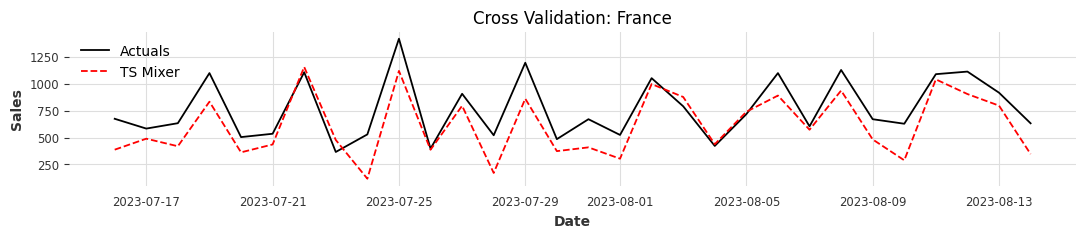

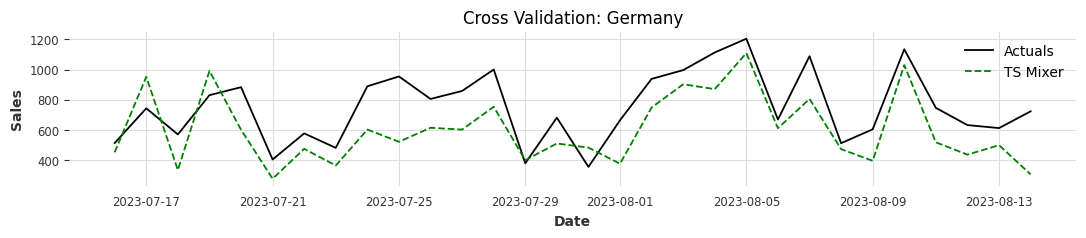

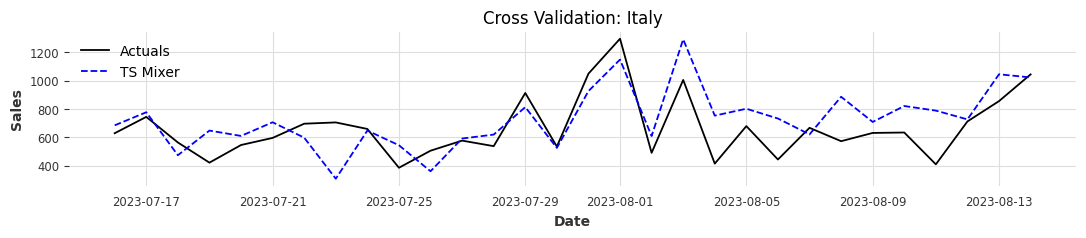

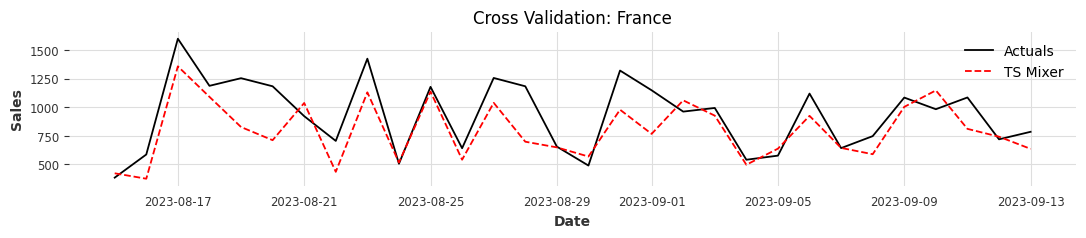

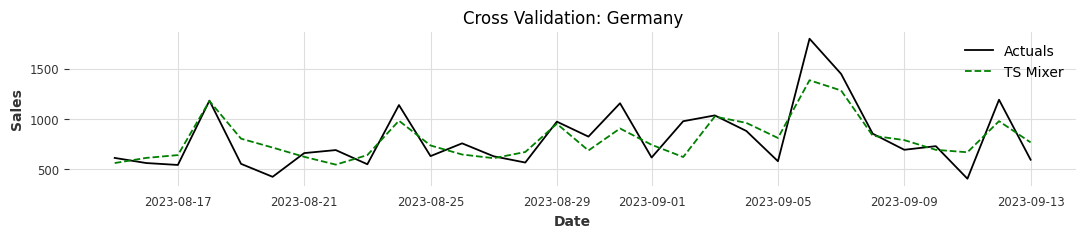

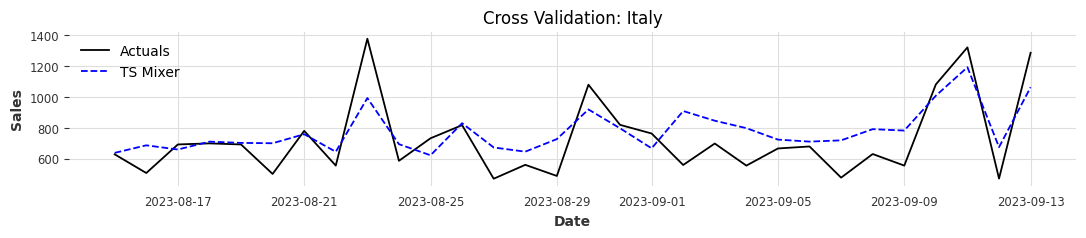

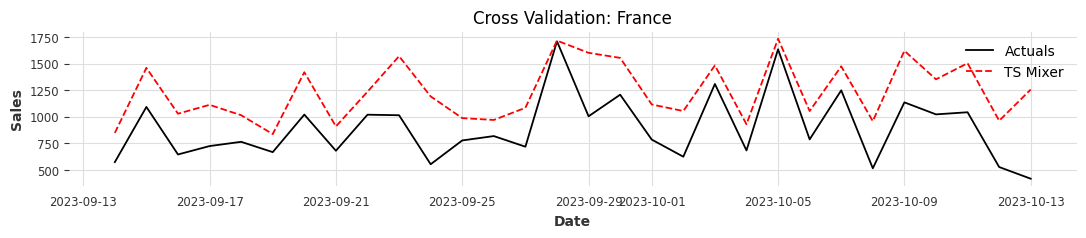

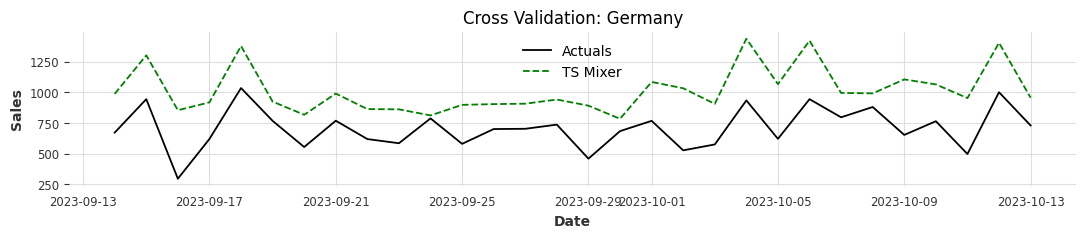

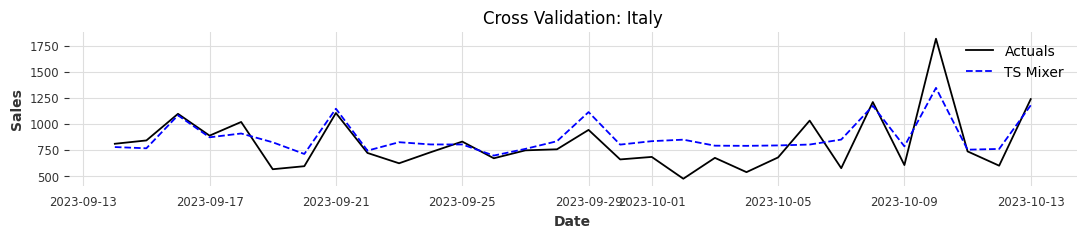

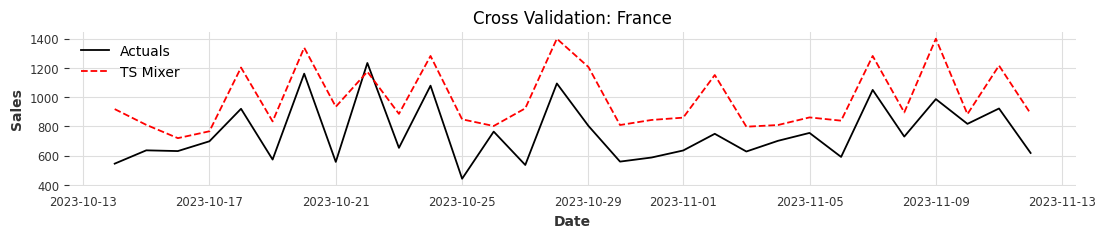

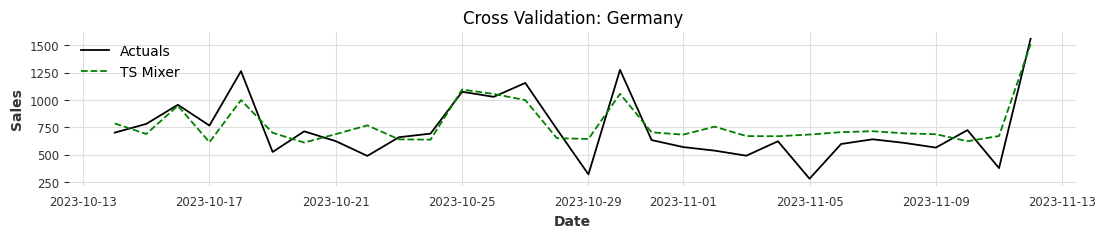

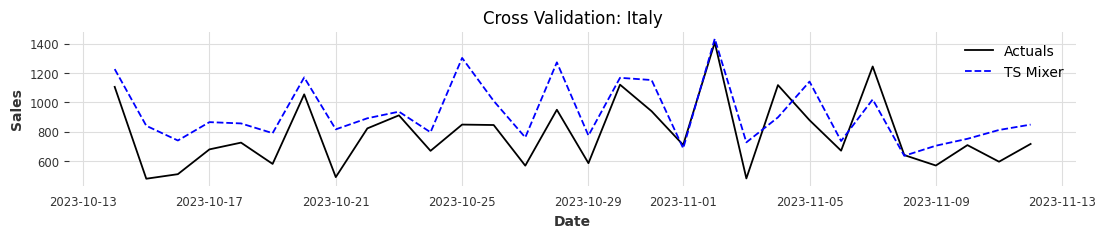

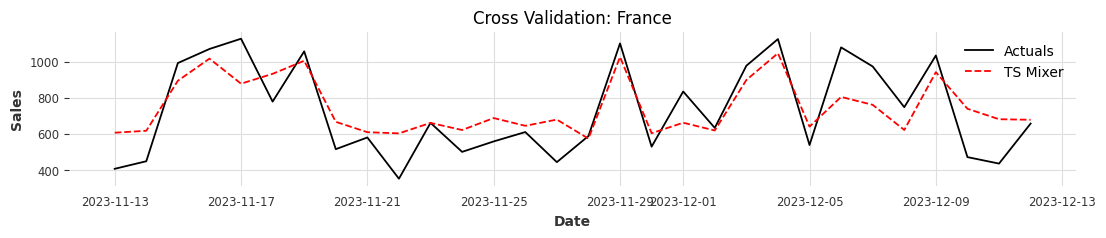

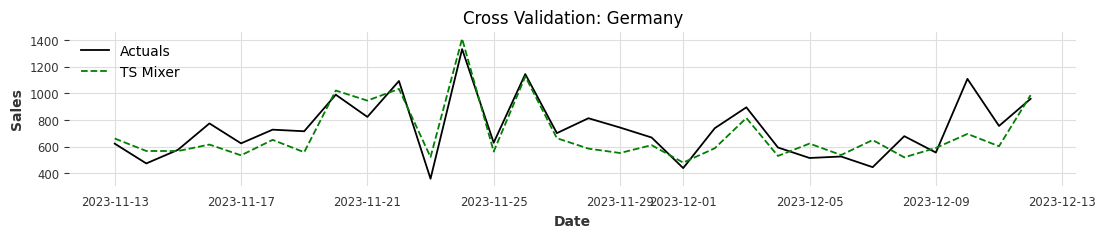

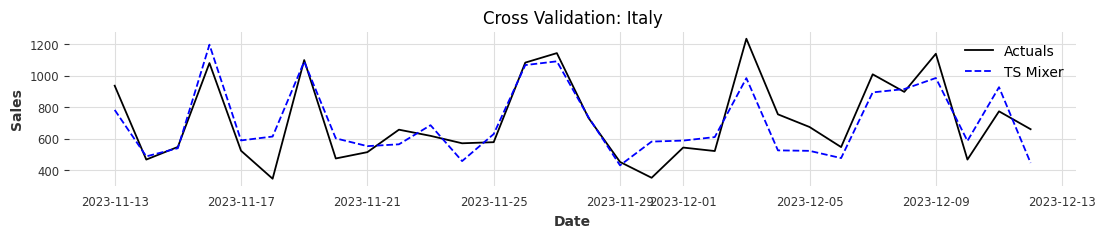

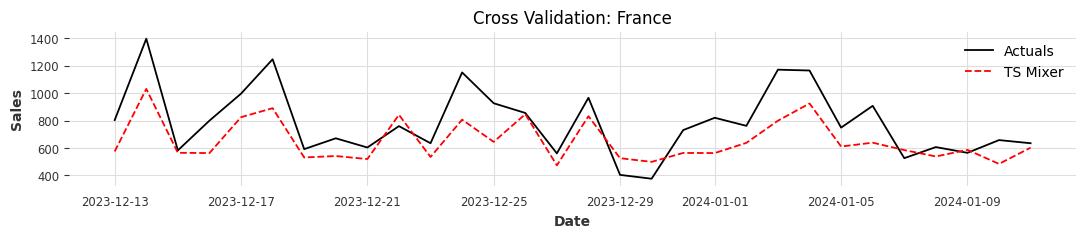

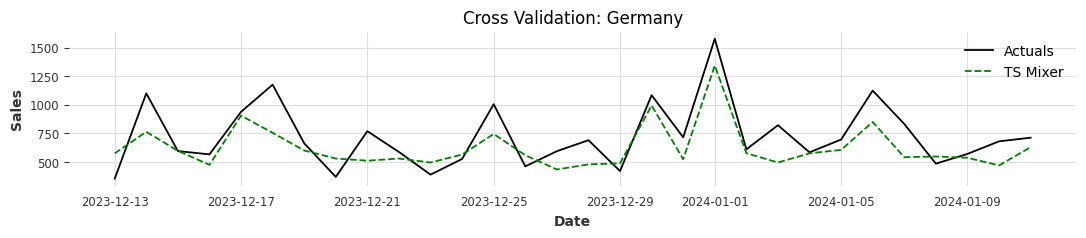

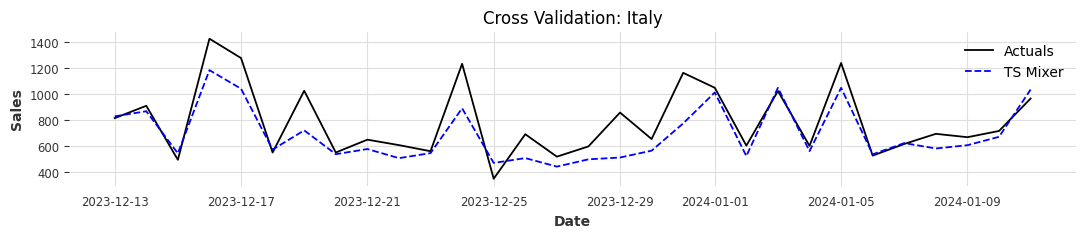

Overall RMSE: 201.64


In [28]:
rmse_cv = []

for j in range(number_backtests):
    period_predictions = []

    # Collect predictions for each series
    for i in range(number_series):
        period_predictions.append(cv[i][j])

    # Unscale predictions
    period_predictions_unscaled = scaler1.inverse_transform(period_predictions)

    series_rmse = []
    for i in range(number_series):
        predictions = period_predictions_unscaled[i]

        # Convert TimeSeries to DataFrame
        predictions_df = pd.DataFrame({
            'ds': predictions.time_index,
            'y': predictions.values().flatten()
        }).set_index('ds')

        # Extract actuals
        start, end = predictions_df.index.min(), predictions_df.index.max()
        actuals = df[(df['ds'] >= start) & (df['ds'] <= end) & (df['location'] == i)]
        actuals = actuals.set_index('ds')['y']

        # Plot
        color_dict = {0: 'red', 1: 'green', 2: 'blue'}
        fig, ax = plt.subplots(figsize=(13, 2))
        ax.plot(actuals, label="Actuals")
        ax.plot(predictions_df['y'], label='TS Mixer', linestyle='dashed', color=color_dict[i])
        ax.legend()
        ax.set_title(f"Cross Validation: {category_mapping[i]}")
        ax.set_xlabel("Date")
        ax.set_ylabel("Sales")
        plt.show()

        # Compute RMSE
        error_cv = np.sqrt(mean_squared_error(actuals, predictions_df['y']))
        series_rmse.append(error_cv)

    # Append mean RMSE for the current period
    rmse_cv.append(np.mean(series_rmse))

# Overall RMSE across all periods and series
print(f"Overall RMSE: {np.mean(rmse_cv):.2f}")


#### Parameter Tuning

In [29]:
# Define the parameter grid for tuning
param_grid = {
    'input_chunk_length': [90, 120, 150],    # Length of input sequence
    'n_epochs': [20],                        # Number of training epochs
    'ff_size': [5, 10, 15],                  # Feedforward layer size
    'num_blocks': [1, 2, 3],                 # Number of blocks per stack
    'hidden_size': [5, 10, 15],              # Hidden layer size
}

In [30]:
# Define parameters that remain constant during the tuning
fixed_params = {
    'output_chunk_length': forecast_horizon,      # Length of the forecast horizon
    'use_reversible_instance_norm': True,         # Use reversible instance normalization
    'random_state': 989,                         # Random seed for reproducibility
    'pl_trainer_kwargs': {'accelerator': 'gpu',   # GPU settings for training
                          'devices': [0]}
}

In [31]:
# Number of random parameter combinations to generate
n_iter = 20

# Generate a list of random parameter combinations for tuning
param_list = list(ParameterSampler(param_grid,
                                   n_iter=n_iter,
                                   random_state=989))

In [32]:
# Update each parameter set in the list with the fixed parameters
for params in param_list:
  params.update(fixed_params)
  print(params)

{'num_blocks': 2, 'n_epochs': 20, 'input_chunk_length': 120, 'hidden_size': 5, 'ff_size': 10, 'output_chunk_length': 30, 'use_reversible_instance_norm': True, 'random_state': 989, 'pl_trainer_kwargs': {'accelerator': 'gpu', 'devices': [0]}}
{'num_blocks': 1, 'n_epochs': 20, 'input_chunk_length': 90, 'hidden_size': 15, 'ff_size': 10, 'output_chunk_length': 30, 'use_reversible_instance_norm': True, 'random_state': 989, 'pl_trainer_kwargs': {'accelerator': 'gpu', 'devices': [0]}}
{'num_blocks': 2, 'n_epochs': 20, 'input_chunk_length': 120, 'hidden_size': 15, 'ff_size': 10, 'output_chunk_length': 30, 'use_reversible_instance_norm': True, 'random_state': 989, 'pl_trainer_kwargs': {'accelerator': 'gpu', 'devices': [0]}}
{'num_blocks': 2, 'n_epochs': 20, 'input_chunk_length': 150, 'hidden_size': 15, 'ff_size': 5, 'output_chunk_length': 30, 'use_reversible_instance_norm': True, 'random_state': 989, 'pl_trainer_kwargs': {'accelerator': 'gpu', 'devices': [0]}}
{'num_blocks': 3, 'n_epochs': 20, '

In [33]:
rmse = []

for params in param_list:
    model = TSMixerModel(**params)

    # Cross-validation with rolling forecasts
    cv = model.historical_forecasts(
        series=y_transformed,
        past_covariates=past_covariates_transformed,
        future_covariates=future_covariates_transformed,
        start=len(y_transformed[0]) - 300,
        forecast_horizon=forecast_horizon,
        stride=forecast_horizon,
        last_points_only=False,
        retrain=True,
        verbose=False,
    )

    rmse_cv = []

    for j in range(number_backtests):
        period_predictions = []

        # Collect predictions for all series
        for i in range(number_series):
            period_predictions.append(cv[i][j])

        # Unscale predictions
        period_predictions_unscaled = scaler1.inverse_transform(period_predictions)

        series_rmse = []
        for i in range(number_series):
            predictions = period_predictions_unscaled[i]

            # Convert TimeSeries to DataFrame
            predictions_df = pd.DataFrame({
                'ds': predictions.time_index,
                'y': predictions.values().flatten()
            }).set_index('ds')

            # Extract actuals for this series
            start, end = predictions_df.index.min(), predictions_df.index.max()
            actuals = df[(df['ds'] >= start) & (df['ds'] <= end) & (df['location'] == i)]
            actuals = actuals.set_index('ds')['y']

            # Compute RMSE
            error_cv = np.sqrt(mean_squared_error(actuals, predictions_df['y']))
            series_rmse.append(error_cv)

        # Mean RMSE for this period
        rmse_cv.append(np.mean(series_rmse))

    # Mean RMSE for this parameter set
    mean_rmse = np.mean(rmse_cv)
    rmse.append(mean_rmse)
    print(f"Tested_params {params} => RMSE: {mean_rmse:.2f}")



Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Tested_params {'num_blocks': 2, 'n_epochs': 20, 'input_chunk_length': 120, 'hidden_size': 5, 'ff_size': 10, 'output_chunk_length': 30, 'use_reversible_instance_norm': True, 'random_state': 989, 'pl_trainer_kwargs': {'accelerator': 'gpu', 'devices': [0]}} => RMSE: 225.29


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Tested_params {'num_blocks': 1, 'n_epochs': 20, 'input_chunk_length': 90, 'hidden_size': 15, 'ff_size': 10, 'output_chunk_length': 30, 'use_reversible_instance_norm': True, 'random_state': 989, 'pl_trainer_kwargs': {'accelerator': 'gpu', 'devices': [0]}} => RMSE: 193.53


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Tested_params {'num_blocks': 2, 'n_epochs': 20, 'input_chunk_length': 120, 'hidden_size': 15, 'ff_size': 10, 'output_chunk_length': 30, 'use_reversible_instance_norm': True, 'random_state': 989, 'pl_trainer_kwargs': {'accelerator': 'gpu', 'devices': [0]}} => RMSE: 206.52


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Tested_params {'num_blocks': 2, 'n_epochs': 20, 'input_chunk_length': 150, 'hidden_size': 15, 'ff_size': 5, 'output_chunk_length': 30, 'use_reversible_instance_norm': True, 'random_state': 989, 'pl_trainer_kwargs': {'accelerator': 'gpu', 'devices': [0]}} => RMSE: 202.21


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Tested_params {'num_blocks': 3, 'n_epochs': 20, 'input_chunk_length': 120, 'hidden_size': 15, 'ff_size': 15, 'output_chunk_length': 30, 'use_reversible_instance_norm': True, 'random_state': 989, 'pl_trainer_kwargs': {'accelerator': 'gpu', 'devices': [0]}} => RMSE: 224.25


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Tested_params {'num_blocks': 2, 'n_epochs': 20, 'input_chunk_length': 90, 'hidden_size': 10, 'ff_size': 10, 'output_chunk_length': 30, 'use_reversible_instance_norm': True, 'random_state': 989, 'pl_trainer_kwargs': {'accelerator': 'gpu', 'devices': [0]}} => RMSE: 184.67


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Tested_params {'num_blocks': 3, 'n_epochs': 20, 'input_chunk_length': 120, 'hidden_size': 15, 'ff_size': 10, 'output_chunk_length': 30, 'use_reversible_instance_norm': True, 'random_state': 989, 'pl_trainer_kwargs': {'accelerator': 'gpu', 'devices': [0]}} => RMSE: 223.75


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Tested_params {'num_blocks': 2, 'n_epochs': 20, 'input_chunk_length': 150, 'hidden_size': 10, 'ff_size': 10, 'output_chunk_length': 30, 'use_reversible_instance_norm': True, 'random_state': 989, 'pl_trainer_kwargs': {'accelerator': 'gpu', 'devices': [0]}} => RMSE: 212.59


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Tested_params {'num_blocks': 1, 'n_epochs': 20, 'input_chunk_length': 150, 'hidden_size': 10, 'ff_size': 5, 'output_chunk_length': 30, 'use_reversible_instance_norm': True, 'random_state': 989, 'pl_trainer_kwargs': {'accelerator': 'gpu', 'devices': [0]}} => RMSE: 202.09


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Tested_params {'num_blocks': 3, 'n_epochs': 20, 'input_chunk_length': 90, 'hidden_size': 15, 'ff_size': 15, 'output_chunk_length': 30, 'use_reversible_instance_norm': True, 'random_state': 989, 'pl_trainer_kwargs': {'accelerator': 'gpu', 'devices': [0]}} => RMSE: 195.85


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Tested_params {'num_blocks': 3, 'n_epochs': 20, 'input_chunk_length': 150, 'hidden_size': 5, 'ff_size': 15, 'output_chunk_length': 30, 'use_reversible_instance_norm': True, 'random_state': 989, 'pl_trainer_kwargs': {'accelerator': 'gpu', 'devices': [0]}} => RMSE: 240.63


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Tested_params {'num_blocks': 3, 'n_epochs': 20, 'input_chunk_length': 150, 'hidden_size': 5, 'ff_size': 10, 'output_chunk_length': 30, 'use_reversible_instance_norm': True, 'random_state': 989, 'pl_trainer_kwargs': {'accelerator': 'gpu', 'devices': [0]}} => RMSE: 224.80


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Tested_params {'num_blocks': 1, 'n_epochs': 20, 'input_chunk_length': 90, 'hidden_size': 15, 'ff_size': 15, 'output_chunk_length': 30, 'use_reversible_instance_norm': True, 'random_state': 989, 'pl_trainer_kwargs': {'accelerator': 'gpu', 'devices': [0]}} => RMSE: 182.59


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Tested_params {'num_blocks': 2, 'n_epochs': 20, 'input_chunk_length': 150, 'hidden_size': 5, 'ff_size': 5, 'output_chunk_length': 30, 'use_reversible_instance_norm': True, 'random_state': 989, 'pl_trainer_kwargs': {'accelerator': 'gpu', 'devices': [0]}} => RMSE: 216.31


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Tested_params {'num_blocks': 2, 'n_epochs': 20, 'input_chunk_length': 90, 'hidden_size': 15, 'ff_size': 5, 'output_chunk_length': 30, 'use_reversible_instance_norm': True, 'random_state': 989, 'pl_trainer_kwargs': {'accelerator': 'gpu', 'devices': [0]}} => RMSE: 188.87


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Tested_params {'num_blocks': 3, 'n_epochs': 20, 'input_chunk_length': 150, 'hidden_size': 10, 'ff_size': 5, 'output_chunk_length': 30, 'use_reversible_instance_norm': True, 'random_state': 989, 'pl_trainer_kwargs': {'accelerator': 'gpu', 'devices': [0]}} => RMSE: 211.87


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Tested_params {'num_blocks': 1, 'n_epochs': 20, 'input_chunk_length': 120, 'hidden_size': 10, 'ff_size': 5, 'output_chunk_length': 30, 'use_reversible_instance_norm': True, 'random_state': 989, 'pl_trainer_kwargs': {'accelerator': 'gpu', 'devices': [0]}} => RMSE: 220.41


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Tested_params {'num_blocks': 3, 'n_epochs': 20, 'input_chunk_length': 90, 'hidden_size': 15, 'ff_size': 10, 'output_chunk_length': 30, 'use_reversible_instance_norm': True, 'random_state': 989, 'pl_trainer_kwargs': {'accelerator': 'gpu', 'devices': [0]}} => RMSE: 189.91


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Tested_params {'num_blocks': 3, 'n_epochs': 20, 'input_chunk_length': 120, 'hidden_size': 5, 'ff_size': 15, 'output_chunk_length': 30, 'use_reversible_instance_norm': True, 'random_state': 989, 'pl_trainer_kwargs': {'accelerator': 'gpu', 'devices': [0]}} => RMSE: 244.87


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Tested_params {'num_blocks': 2, 'n_epochs': 20, 'input_chunk_length': 150, 'hidden_size': 10, 'ff_size': 5, 'output_chunk_length': 30, 'use_reversible_instance_norm': True, 'random_state': 989, 'pl_trainer_kwargs': {'accelerator': 'gpu', 'devices': [0]}} => RMSE: 213.80


In [34]:
# Create a DataFrame from the list of parameters
results_df = pd.DataFrame(param_list)
results_df['rmse'] = rmse
results_df

num_blocks  n_epochs  input_chunk_length  hidden_size  ff_size  \
0            2        20                 120            5       10   
1            1        20                  90           15       10   
2            2        20                 120           15       10   
3            2        20                 150           15        5   
4            3        20                 120           15       15   
5            2        20                  90           10       10   
6            3        20                 120           15       10   
7            2        20                 150           10       10   
8            1        20                 150           10        5   
9            3        20                  90           15       15   
10           3        20                 150            5       15   
11           3        20                 150            5       10   
12           1        20                  90           15       15   
13           2        20                 150            5        5   
14           2        20                  90           15        5   
15           3        20                 150           10        5   
16           1        20                 120           10        5   
17           3        20                  90           15       10   
18           3        20                 120            5       15   
19           2        20                 150           10        5   

    output_chunk_length  use_reversible_instance_norm  random_state  \
0                    30                          True           989   
1                    30                          True           989   
2                    30                          True           989   
3                    30                          True           989   
4                    30                          True           989   
5                    30                          True           989   
6                    30                          True           989   
7                    30                          True           989   
8                    30                          True           989   
9                    30                          True           989   
10                   30                          True           989   
11                   30                          True           989   
12                   30                          True           989   
13                   30                          True           989   
14                   30                          True           989   
15                   30                          True           989   
16                   30                          True           989   
17                   30                          True           989   
18                   30                          True           989   
19                   30                          True           989   

                         pl_trainer_kwargs        rmse  
0   {'accelerator': 'gpu', 'devices': [0]}  225.294771  
1   {'accelerator': 'gpu', 'devices': [0]}  193.528571  
2   {'accelerator': 'gpu', 'devices': [0]}  206.524324  
3   {'accelerator': 'gpu', 'devices': [0]}  202.206892  
4   {'accelerator': 'gpu', 'devices': [0]}  224.246134  
5   {'accelerator': 'gpu', 'devices': [0]}  184.667409  
6   {'accelerator': 'gpu', 'devices': [0]}  223.746563  
7   {'accelerator': 'gpu', 'devices': [0]}  212.586999  
8   {'accelerator': 'gpu', 'devices': [0]}  202.093160  
9   {'accelerator': 'gpu', 'devices': [0]}  195.852243  
10  {'accelerator': 'gpu', 'devices': [0]}  240.632265  
11  {'accelerator': 'gpu', 'devices': [0]}  224.797622  
12  {'accelerator': 'gpu', 'devices': [0]}  182.593113  
13  {'accelerator': 'gpu', 'devices': [0]}  216.305649  
14  {'accelerator': 'gpu', 'devices': [0]}  188.867480  
15  {'accelerator': 'gpu', 'devices': [0]}  211.868169  
16  {'accelerator': 'gpu', 'devices': [0]}  220.408160  
17  {'accelerat

In [35]:
# Identify the parameter set(s) with the lowest RMSE and export it to a CSV file
best_params = results_df[results_df['rmse'] == results_df['rmse'].min()]
best_params.to_csv("best_params.csv")

#### Predict the future

In [36]:
# Load the best parameters from the CSV file, and put it in a dictionary
best_params = pd.read_csv('best_params.csv', index_col =0).drop(columns = ["rmse", "pl_trainer_kwargs"])
best_params_dict= best_params.squeeze().to_dict()

In [37]:
# Transform each of the params into integers
for key, value in best_params_dict.items():
  try:
    best_params_dict[key] = int(value)
  except (TypeError, ValueError):
    pass

# best_params_dict['pl_trainer_kwargs'] = {'accelerator': 'gpu', 'devices': [0]}
best_params_dict['pl_trainer_kwargs'] = {"accelerator": "cpu"}

best_params_dict

{'num_blocks': 1,
 'n_epochs': 20,
 'input_chunk_length': 90,
 'hidden_size': 15,
 'ff_size': 15,
 'output_chunk_length': 30,
 'use_reversible_instance_norm': 1,
 'random_state': 989,
 'pl_trainer_kwargs': {'accelerator': 'cpu'}}

In [38]:
# Build the tuned model with the best parameters
tuned_model = TSMixerModel(**best_params_dict)

# Fit the tuned model
tuned_model.fit(y_transformed,
                past_covariates = past_covariates_transformed,
                future_covariates = future_covariates_transformed)

Training: |          | 0/? [00:00<?, ?it/s]

TSMixerModel(output_chunk_shift=0, hidden_size=15, ff_size=15, num_blocks=1, activation=ReLU, dropout=0.1, norm_type=LayerNorm, normalize_before=False, use_static_covariates=True, n_epochs=20, input_chunk_length=90, output_chunk_length=30, use_reversible_instance_norm=1, random_state=989, pl_trainer_kwargs={'accelerator': 'cpu'})

In [39]:
# Generate forecasts for the future using the tuned model
forecast_scaled = tuned_model.predict(n=forecast_horizon,
                         series = y_transformed,
                         past_covariates = past_covariates_transformed,
                         future_covariates = future_covariates_transformed)

Predicting: |          | 0/? [00:00<?, ?it/s]

In [40]:
# Convert the scaled forecast values back to their original scale
forecast = scaler1.inverse_transform(forecast_scaled)

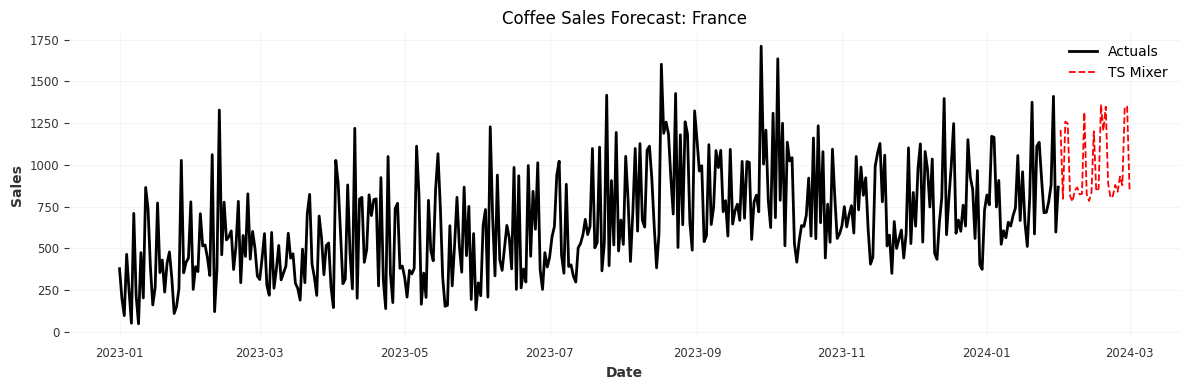

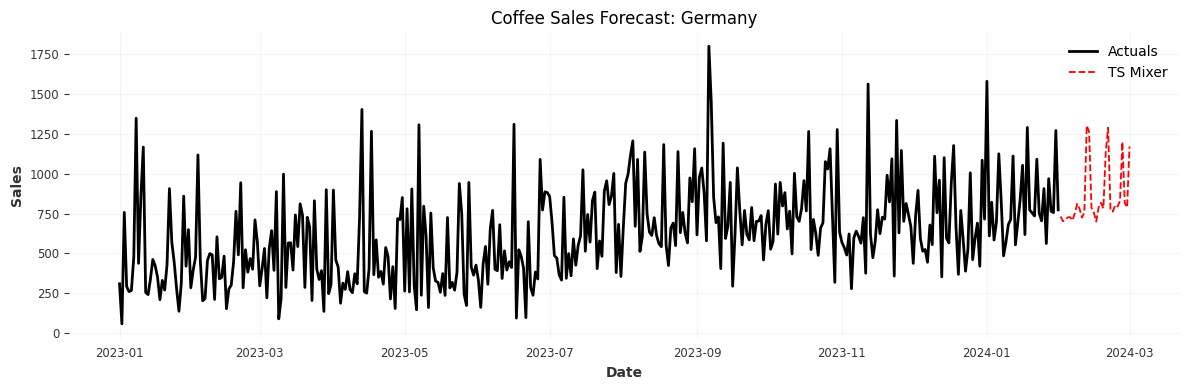

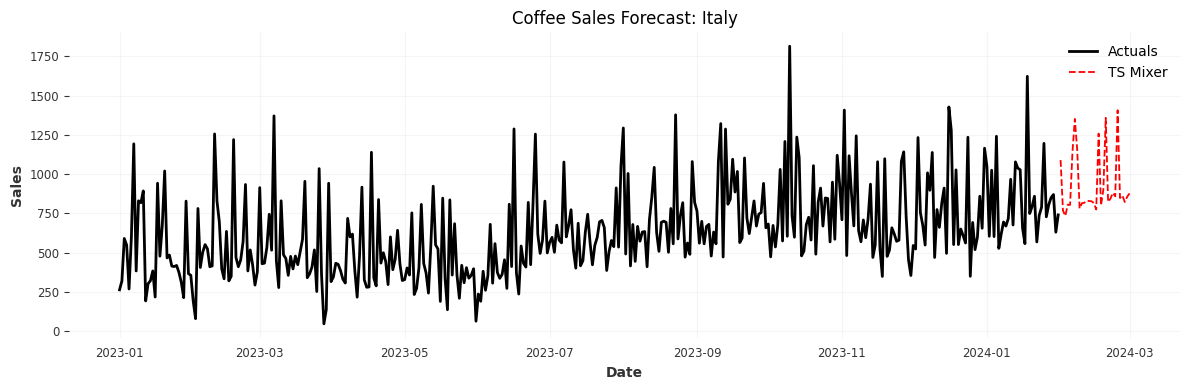

In [49]:
for i in range(len(forecast)):
    fig, ax = plt.subplots(figsize=(12, 4))

    # Plot the actual values for this location
    actual_series = temp_df[temp_df['location'] == i]['y']
    ax.plot(actual_series.index, actual_series.values, label="Actuals", linewidth=2)

    # Convert TimeSeries forecast to pandas Series
    forecast_series = pd.Series(
        data=forecast[i].values().flatten(),
        index=forecast[i].time_index,
        name="TS Mixer"
    )

    # Plot forecasted values
    ax.plot(forecast_series.index, forecast_series.values, label='TS Mixer', linestyle='dashed', color='red')

    # Add legend, title, and axis labels
    ax.legend()
    ax.set_title(f"Coffee Sales Forecast: {category_mapping[i]}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Sales")
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
